In [3]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/creditcard_prediction/data
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/IITP/sohyun/creditcard_prediction/data'
/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data
/content/drive/My Drive/IITP/sohyun/creditcard_prediction/data


In [4]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: Currently logged in as: sohyun. Use `wandb login --relogin` to force relogin


True

## Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode :
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x), 0
        
    def __len__(self):
        return len(self.df)

# train_dataset = MyDataset(df=train_df, eval_mode=False)
# train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)

# val_dataset = MyDataset(df = val_df, eval_mode=True)
# val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

import pandas as pd
from sklearn.preprocessing import StandardScaler
def get_loader(data_path, batch_size, mode='train'):
    """Build and return data loader."""
    train_df = pd.read_csv('./train.csv')
    train_df = train_df.drop(columns=['ID'])
    val_df = pd.read_csv('./val.csv')
    val_df = val_df.drop(columns=['ID'])
    test_df = pd.read_csv('./test.csv')
    test_df = test_df.drop(columns=['ID'])

    #-------------------#
    #---# Normalize #---#
    #-------------------#
    # case 1 - standardscaler
    scaler_n = StandardScaler()
    scaler_n.fit(train_df)
    
    val_x = val_df.drop(columns=['Class'])
    train_x_scaleN = pd.DataFrame(scaler_n.transform(train_df), columns = train_df.columns) # 확인 : train_x_scaleN.mean(), train_x_scaleN.var()
    val_x_scaleN = pd.DataFrame(scaler_n.transform(val_x), columns = val_x.columns)
    test_x_scaleN = pd.DataFrame(scaler_n.transform(test_df), columns = test_df.columns)

    train_df = train_x_scaleN
    val_df = pd.concat([val_x_scaleN, pd.DataFrame(val_df['Class'])])
    test_df = test_x_scaleN
    
    # dataset = MyDataset(data_path, mode)
    train_dataset = MyDataset(df=train_df, eval_mode=False)
    valid_dataset = MyDataset(df=val_df, eval_mode=True)
    test_dataset = MyDataset(df=test_df, eval_mode=False)
    
    shuffle = False
    if mode == 'train': shuffle = True

    data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
    data_loader_v = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=shuffle)
    data_loader_test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader, data_loader_v, data_loader_test


In [6]:
class EarlyStopping:
  def __init__(self, patience=30):
      self.loss = np.inf
      self.patience = 0
      self.patience_limit = patience
      
  def step(self, loss):
      if self.loss > loss:
          self.loss = loss
          self.patience = 0
      else:
          self.patience += 1
  
  def is_stop(self):
      return self.patience >= self.patience_limit

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
from torch.autograd import grad
from torch.autograd import Variable
# from model import *
import matplotlib.pyplot as plt
# from utils import *
# from data_loader import *
import IPython
from tqdm import tqdm

class Solver(object):
    DEFAULTS = {}   
    def __init__(self, device, data_loader, data_loader_v, data_loader_test, config):
        # Data loader
        self.__dict__.update(Solver.DEFAULTS, **config)
        self.data_loader = data_loader
        self.data_loader_v = data_loader_v
        self.data_loader_test = data_loader_test
        self.device = device

        # Build tensorboard if use
        self.build_model()
        if self.use_tensorboard:self.build_tensorboard()

        # Start with trained model
        if self.pretrained_model: self.load_pretrained_model()

    def build_model(self):
        # Define model
        self.dagmm = DaGMM(self.device, self.gmm_k)

        # Optimizers
        self.optimizer = torch.optim.Adam(self.dagmm.parameters(), lr=self.lr)

        # Print networks
        self.print_network(self.dagmm, 'DaGMM')

        if torch.cuda.is_available():
            self.dagmm.cuda()

    def print_network(self, model, name):
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(name)
        # print(model)
        print("The number of parameters: {}".format(num_params))

    def load_pretrained_model(self):
        self.dagmm.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_dagmm.pth'.format(self.pretrained_model))))

        print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)

        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    # def build_tensorboard(self):
    #     from logger import Logger
    #     self.logger = Logger(self.log_path)

    def reset_grad(self):
        self.dagmm.zero_grad()

    def to_var(self, x, volatile=False):
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x, volatile=volatile)

    def train(self):
        iters_per_epoch = len(self.data_loader)

        # Start with trained model if exists
        if self.pretrained_model:
            start = int(self.pretrained_model.split('_')[0])
        else:
            start = 0

        # Start training
        iter_ctr = 0
        start_time = time.time()

        self.ap_global_train = np.array([0,0,0])
        best_loss = -1
        early_stop = EarlyStopping(patience=30)
        for e in range(start, self.num_epochs):
            for i, (input_data, labels) in enumerate(tqdm(self.data_loader)):
                iter_ctr += 1
                start = time.time()

                input_data = self.to_var(input_data)

                total_loss,sample_energy, recon_error, cov_diag = self.dagmm_step(input_data)

                early_stop.step(total_loss.item())
                if early_stop.is_stop() : break

                # Logging
                loss = {}
                loss['total_loss'] = total_loss.data.item()
                loss['sample_energy'] = sample_energy.item()
                loss['recon_error'] = recon_error.item()
                loss['cov_diag'] = cov_diag.item()

                # Print out log info
                if (i+1) % self.log_step == 0:
                    elapsed = time.time() - start_time
                    total_time = ((self.num_epochs*iters_per_epoch)-(e*iters_per_epoch+i)) * elapsed/(e*iters_per_epoch+i+1)
                    epoch_time = (iters_per_epoch-i)* elapsed/(e*iters_per_epoch+i+1)
                    
                    epoch_time = str(datetime.timedelta(seconds=epoch_time))
                    total_time = str(datetime.timedelta(seconds=total_time))
                    elapsed = str(datetime.timedelta(seconds=elapsed))

                    lr_tmp = []
                    for param_group in self.optimizer.param_groups:
                        lr_tmp.append(param_group['lr'])
                    tmplr = np.squeeze(np.array(lr_tmp))

                    log = "Elapsed {}/{} -- {} , Epoch [{}/{}], Iter [{}/{}], lr {}".format(
                        elapsed,epoch_time,total_time, e+1, self.num_epochs, i+1, iters_per_epoch, tmplr)

                    for tag, value in loss.items():
                        log += ", {}: {:.4f}".format(tag, value)

                    # IPython.display.clear_output() ## clear
                    # print(log)

                    if self.use_tensorboard:
                        for tag, value in loss.items():
                            self.logger.scalar_summary(tag, value, e * iters_per_epoch + i + 1)
                    else:
                        plt_ctr = 1
                        if not hasattr(self,"loss_logs"):
                            self.loss_logs = {}
                            for loss_key in loss:
                                self.loss_logs[loss_key] = [loss[loss_key]]
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                        else:
                            for loss_key in loss:
                                self.loss_logs[loss_key].append(loss[loss_key])
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1

                        plt.show()

                    # print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)
                    
                # Save model checkpoints
                # if (i+1) % self.model_save_step == 0:
                #     torch.save(self.dagmm.state_dict(),
                #         os.path.join(self.model_save_path, '{}_{}_dagmm.pth'.format(e+1, i+1)))
                
                ###############################################################
                
            for i, (input_data, labels) in enumerate(tqdm(self.data_loader_v)):
                iter_ctr += 1
                start = time.time()

                input_data = self.to_var(input_data)
                total_loss_v, sample_energy_v, recon_error_v, cov_diag_v = self.dagmm_step(input_data)
                
                wandb.log({"loss_v":total_loss_v.item(),
                            "cov_diag_v":cov_diag_v.item()})
                # Logging
                loss_v = {}
                loss_v['total_loss'] = total_loss_v.data.item()
                loss_v['sample_energy'] = sample_energy_v.item()
                loss_v['recon_error'] = recon_error_v.item()
                loss_v['cov_diag'] = cov_diag_v.item()

                # Print out log info
                elapsed = time.time() - start_time
                total_time = ((self.num_epochs*iters_per_epoch)-(e*iters_per_epoch+i)) * elapsed/(e*iters_per_epoch+i+1)
                epoch_time = (iters_per_epoch-i) * elapsed/(e*iters_per_epoch+i+1)
                epoch_time = str(datetime.timedelta(seconds=epoch_time))
                total_time = str(datetime.timedelta(seconds=total_time))
                elapsed = str(datetime.timedelta(seconds=elapsed))

                lr_tmp = []
                for param_group in self.optimizer.param_groups : lr_tmp.append(param_group['lr'])
                tmplr = np.squeeze(np.array(lr_tmp))

                log = "Elapsed {}/{} -- {} , Epoch [{}/{}], Iter [{}/{}], lr {}".format(elapsed,epoch_time,total_time, e+1, self.num_epochs, i+1, iters_per_epoch, tmplr)

                for tag, value in loss.items() : log += ", {}: {:.4f}".format(tag, value)
                # IPython.display.clear_output() ## clear
                # print(log)

                if best_loss < total_loss_v.data.item() :
                    torch.save(self.dagmm.state_dict(), os.path.join(self.model_save_path, '{}_{}_dagmm.pth'.format(e+1, i+1)))


    def dagmm_step(self, input_data):
        self.dagmm.train()
        enc, dec, z, gamma = self.dagmm(input_data)
        total_loss, sample_energy, recon_error, cov_diag = self.dagmm.loss_function(input_data, dec, z, gamma, self.lambda_energy, self.lambda_cov_diag)
        
        self.reset_grad()
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.dagmm.parameters(), 5)
        self.optimizer.step()

        return total_loss,sample_energy, recon_error, cov_diag


    def test(self):
        print("======================TEST MODE======================")
        self.dagmm.eval()
        self.data_loader.dataset.mode="train"
        ########################################################################
        N = 0; mu_sum = 0; cov_sum = 0; gamma_sum = 0

        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            phi, mu, cov = self.dagmm.compute_gmm_params(z, gamma)
            
            batch_gamma_sum = torch.sum(gamma, dim=0)
            
            gamma_sum += batch_gamma_sum
            mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
            cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
            
            N += input_data.size(0)
            
        train_phi = gamma_sum / N
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)
        
        # print("N:",N)
        # print("phi :\n",train_phi)
        # print("mu :\n",train_mu)
        # print("cov :\n",train_cov)

        train_energy = []
        train_labels = []
        train_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
            
            train_energy.append(sample_energy.data.cpu().numpy())
            train_z.append(z.data.cpu().numpy())
            # train_labels.append(labels.numpy())

        train_energy = np.concatenate(train_energy,axis=0)
        train_z = np.concatenate(train_z,axis=0)
        # train_labels = np.concatenate(train_labels,axis=0)
        ########################################################################
        N = 0; mu_sum = 0; cov_sum = 0; gamma_sum = 0

        for it, (input_data, labels) in enumerate(self.data_loader_v):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            phi, mu, cov = self.dagmm.compute_gmm_params(z, gamma)
            
            batch_gamma_sum = torch.sum(gamma, dim=0)
            
            gamma_sum += batch_gamma_sum
            mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
            cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
            
            N += input_data.size(0)
            
        val_phi = gamma_sum / N
        val_mu = mu_sum / gamma_sum.unsqueeze(-1)
        val_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)
        
        # print("N:",N)
        # print("phi :\n",train_phi)
        # print("mu :\n",train_mu)
        # print("cov :\n",train_cov)

        val_energy = []
        val_labels = []
        val_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, phi=val_phi, mu=val_mu, cov=val_cov, size_average=False)
            
            val_energy.append(sample_energy.data.cpu().numpy())
            val_z.append(z.data.cpu().numpy())
            val_labels.append(labels.numpy())

        val_energy = np.concatenate(val_energy,axis=0)
        val_z = np.concatenate(val_z,axis=0)
        val_labels = np.concatenate(val_labels,axis=0)

        ########################################################################
        self.data_loader.dataset.mode="test"
        test_energy = []; test_labels = []; test_z = []
        for it, (input_data, labels) in enumerate(self.data_loader_test):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, size_average=False)
            test_energy.append(sample_energy.data.cpu().numpy())
            test_z.append(z.data.cpu().numpy())
            # test_labels.append(labels.numpy())

        test_energy = np.concatenate(test_energy,axis=0)
        test_z = np.concatenate(test_z,axis=0)
        # test_labels = np.concatenate(test_labels,axis=0)

        combined_energy = np.concatenate([train_energy, val_energy, test_energy], axis=0)
        # combined_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

        thresh = np.percentile(combined_energy, 100 - 0.01)
        # print("Threshold :", thresh)

        pred = (test_energy > thresh).astype(int)
        # gt = test_labels.astype(int)

        from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score
        # accuracy = accuracy_score(gt,pred)
        # precision, recall, f_score, support = prf(gt, pred, average='binary')
        # print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy, precision, recall, f_score))
        # return accuracy, precision, recall, f_score
        return pred, val_z, val_labels

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.autograd import Variable
import itertools
# from utils import *

class Cholesky(torch.autograd.Function):
    def forward(ctx, a):
        # l = torch.potrf(a, False)
        try:
          # l = torch.linalg.cholesky(a, False)
          l = torch.cholesky(a, False)
          ctx.save_for_backward(l)
        except:
          print("-------")
          print(a)
          print("-------")
        return l
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s
    
class DaGMM(nn.Module):
    """Residual Block."""
    def __init__(self, device, n_gmm = 2, latent_dim=130):
        super(DaGMM, self).__init__()
        self.device = device
        
        layers = []
        layers += [nn.Linear(30, 64)]
        layers += [nn.BatchNorm1d(64)]
        layers += [nn.LeakyReLU()]
        layers += [nn.Linear(64,128)]
        layers += [nn.BatchNorm1d(128)]
        layers += [nn.LeakyReLU()]
        self.encoder = nn.Sequential(*layers)
      
        layers = []
        layers += [nn.Linear(128, 64)]
        layers += [nn.BatchNorm1d(64)]
        layers += [nn.LeakyReLU()]
        layers += [nn.Linear(64,30)]
        self.decoder = nn.Sequential(*layers)
        
        # layers = []
        # layers += [nn.Linear(30,60)] #####
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(60,30)]
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(30,10)]
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(10,1)]
        # self.encoder = nn.Sequential(*layers)

        # layers = []
        # layers += [nn.Linear(1,10)]
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(10,30)]
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(30,60)]
        # layers += [nn.Tanh()]        
        # layers += [nn.Linear(60,30)]
        # self.decoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Linear(latent_dim,10)]
        layers += [nn.Tanh()]        
        layers += [nn.Dropout(p=0.5)]        
        layers += [nn.Linear(10,n_gmm)]
        layers += [nn.Softmax(dim=1)]
        self.estimation = nn.Sequential(*layers)

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm,latent_dim))
        self.register_buffer("cov", torch.zeros(n_gmm,latent_dim,latent_dim))

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)

        rec_cosine = F.cosine_similarity(x, dec, dim=1)
        rec_euclidean = self.relative_euclidean_distance(x, dec)
        z = torch.cat([enc, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)

        print("======================= z ==================\n", z)
        print("======================= enc ==================\n", enc)
        print("======================= dec ==================\n", dec)
        print("======================= cosines ==================\n", rec_cosine)
        print("======================= euclidean ==================\n", rec_euclidean)
        print("xxxx\n", x, "\n")
        gamma = self.estimation(z)
        return enc, dec, z, gamma

    def compute_gmm_params(self, z, gamma):
        N = gamma.size(0)
        # K
        sum_gamma = torch.sum(gamma, dim=0)

        # K
        phi = (sum_gamma / N)
        self.phi = phi.data
 
        # K x D
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
        self.mu = mu.data
        # z = N x D
        # mu = K x D
        # gamma N x K

        # z_mu = N x K x D
        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        # z_mu_outer = N x K x D x D
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)

        # K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        self.cov = cov.data
        return phi, mu, cov
        
    def compute_energy(self, z, phi=None, mu=None, cov=None, size_average=True):
        if phi is None : phi = self.phi #self.to_var(self.phi)
        if mu is None : mu = self.mu # self.to_var(self.mu)
        if cov is None : cov = self.cov #self.to_var(self.cov)

        k, D, _ = cov.size()
        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        cov_inverse = []
        det_cov = []
        cov_diag = 0
        eps = 1e-12
        for i in range(k):
            # K x D x D
            # cov_k = cov[i] + self.to_var(torch.eye(D)*eps)
            cov_k = cov[i] + (torch.eye(D)*eps).to(device = self.device)
            cov_inverse.append(torch.inverse(cov_k).unsqueeze(0))
            
            if np.isnan((cov_k.cpu() * (2*np.pi))[0,0].item()) : 
              print(cov_k)
              import time; time.sleep(30)
              continue
            #det_cov.append(np.linalg.det(cov_k.data.cpu().numpy()* (2*np.pi)))
            det_cov.append((Cholesky.apply(cov_k.cpu() * (2*np.pi)).diag().prod()).unsqueeze(0))
            cov_diag = cov_diag + torch.sum(1 / cov_k.diag())

        # K x D x D
        cov_inverse = torch.cat(cov_inverse, dim=0)
        # K
        det_cov = torch.cat(det_cov).cuda()
        #det_cov = to_var(torch.from_numpy(np.float32(np.array(det_cov))))

        # N x K
        exp_term_tmp = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        # for stability (logsumexp)
        max_val = torch.max((exp_term_tmp).clamp(min=0), dim=1, keepdim=True)[0]
        exp_term = torch.exp(exp_term_tmp - max_val)

        # sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (det_cov).unsqueeze(0), dim = 1) + eps)
        sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim = 1) + eps)
        # sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt((2*np.pi)**D * det_cov)).unsqueeze(0), dim = 1) + eps)

        if size_average : sample_energy = torch.mean(sample_energy)
        return sample_energy, cov_diag

    def to_var(x, volatile=False):
        if torch.cuda.is_available() : x = x.cuda()
        print("=====", x)
        import time
        # time.sleep(30)
        return Variable(x, volatile=volatile)

    def loss_function(self, x, x_hat, z, gamma, lambda_energy, lambda_cov_diag):
        recon_error = torch.mean((x - x_hat) ** 2)
        phi, mu, cov = self.compute_gmm_params(z, gamma)
        sample_energy, cov_diag = self.compute_energy(z, phi, mu, cov)
        loss = recon_error + lambda_energy * sample_energy + lambda_cov_diag * cov_diag
        return loss, sample_energy, recon_error, cov_diag


------------ Options -------------
batch_size: 1024
data_path: ./
gmm_k: 4
lambda_cov_diag: 0.005
lambda_energy: 0.1
log_path: ./logs
log_step: 10
lr: 0.0001
mode: train
model_save_path: ./models
model_save_step: 194
num_epochs: 100
pretrained_model: 
sample_step: 194
use_tensorboard: False
-------------- End ----------------


DaGMM
The number of parameters: 22376


  2%|▏         | 2/112 [00:00<00:06, 16.40it/s]

======================= z ==================
 tensor([[ 4.4450e-01, -2.3901e-02,  5.5881e-02,  ...,  6.2835e-01,
          1.2091e+00, -3.6145e-01],
        [ 1.5384e-01, -2.2816e-04, -9.1733e-03,  ...,  3.1131e-01,
          1.1588e+00, -2.3789e-02],
        [-3.0437e-03, -2.5933e-03,  9.1806e-03,  ...,  1.6689e-01,
          1.0950e+00,  3.2378e-02],
        ...,
        [-1.3816e-03,  9.6433e-01, -4.9627e-03,  ..., -3.2326e-03,
          1.0653e+00,  2.9148e-02],
        [ 8.3143e-02,  4.3766e-01,  2.9640e-01,  ..., -4.4451e-03,
          1.2034e+00, -2.7639e-02],
        [-1.0250e-03,  1.5687e+00, -2.2303e-03,  ..., -1.4345e-02,
          1.0625e+00,  4.2458e-02]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 4.4450e-01, -2.3901e-02,  5.5881e-02,  ..., -5.0714e-03,
          8.8943e-01,  6.2835e-01],
        [ 1.5384e-01, -2.2816e-04, -9.1733e-03,  ..., -9.0899e-03,
         -6.0128e-04,  3.1131e-01],
        [-3.0437e-03, -2.59

  6%|▋         | 7/112 [00:00<00:05, 17.96it/s]

tensor([[ 3.6392e-01,  7.1238e-01,  1.3657e+00,  ..., -8.4713e-03,
          9.7355e-01,  2.4678e-01],
        [-5.4369e-03,  1.1732e-01,  3.0996e-01,  ..., -1.6540e-03,
          9.3774e-01,  3.5093e-01],
        [ 5.3890e-01,  8.1658e-01, -1.4941e-02,  ...,  7.5894e-01,
          1.2061e+00, -3.9372e-01],
        ...,
        [-7.6692e-04, -1.7148e-04,  2.2012e-01,  ..., -3.8216e-03,
          9.9190e-01,  1.5606e-01],
        [-6.6234e-04,  1.4130e+00, -1.1031e-03,  ..., -9.7295e-03,
          1.0126e+00,  1.1857e-01],
        [-1.6573e-02,  2.0684e+00,  7.6398e-01,  ..., -1.2776e-02,
          1.0914e+00, -2.1013e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 3.6392e-01,  7.1238e-01,  1.3657e+00,  ..., -5.8796e-03,
         -4.3683e-03, -8.4713e-03],
        [-5.4369e-03,  1.1732e-01,  3.0996e-01,  ...,  1.1043e-01,
          1.8050e-01, -1.6540e-03],
        [ 5.3890e-01,  8.1658e-01, -1.4941e-02,  ...,  1.2543e+00,
      

  8%|▊         | 9/112 [00:00<00:05, 18.31it/s]

tensor([1.0836, 0.9150, 0.9138,  ..., 1.1358, 1.2595, 1.0558], device='cuda:0',
       grad_fn=<DivBackward0>)
xxxx
 tensor([[ 0.4713, -1.5403, -2.2002,  ...,  0.0403,  2.4877,  0.5167],
        [-0.5819,  1.1510,  0.9900,  ...,  0.7797, -0.2665,  0.0083],
        [ 0.5943, -0.7007,  0.4215,  ...,  0.0934,  0.1537, -0.2612],
        ...,
        [-0.1851,  0.6234,  0.1387,  ...,  0.0312, -0.2943,  1.5621],
        [-0.0206,  0.7374, -1.0512,  ...,  0.3312,  0.1007,  1.1688],
        [ 0.3225, -0.4293,  0.4140,  ..., -0.5067, -0.3208,  1.5358]],
       device='cuda:0') 

======================= z ==================
 tensor([[ 4.4721e-01,  5.2810e-01,  4.4816e-01,  ..., -5.4876e-03,
          1.1418e+00, -2.0640e-01],
        [-4.6383e-05,  4.3147e-01,  1.2066e+00,  ...,  6.7468e-01,
          1.0742e+00,  3.0013e-02],
        [-1.7494e-02,  1.0775e+00, -1.0893e-02,  ...,  4.6540e-01,
          1.1103e+00, -6.3301e-02],
        ...,
        [ 1.2915e+00,  4.4087e-01,  2.7259e-02,  ...,  

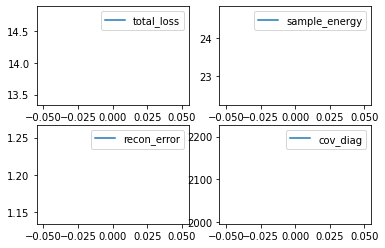

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 12%|█▎        | 14/112 [00:01<00:11,  8.76it/s]

======================= z ==================
 tensor([[ 1.4853e+00, -3.5786e-03, -5.0288e-03,  ..., -6.2782e-03,
          1.0231e+00, -6.8545e-03],
        [ 2.5424e-01, -8.6993e-03,  3.2847e-01,  ...,  1.5461e+00,
          1.1131e+00, -9.9072e-02],
        [-1.0254e-02,  9.1917e-01, -1.7138e-03,  ..., -5.0129e-04,
          9.8270e-01,  2.5456e-01],
        ...,
        [-1.8653e-02,  6.4305e-01, -8.1158e-03,  ...,  7.9074e-01,
          1.1496e+00, -1.8474e-01],
        [-1.3301e-02,  2.0459e+00, -3.2428e-03,  ..., -1.0374e-02,
          9.6790e-01,  2.6622e-01],
        [ 2.0563e-01, -1.2830e-02,  2.3924e+00,  ...,  5.0976e-01,
          1.0240e+00,  2.3983e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 1.4853e+00, -3.5786e-03, -5.0288e-03,  ...,  5.3116e-01,
         -2.1082e-04, -6.2782e-03],
        [ 2.5424e-01, -8.6993e-03,  3.2847e-01,  ..., -9.3836e-03,
          5.2599e-01,  1.5461e+00],
        [-1.0254e-02,  9.19

 14%|█▍        | 16/112 [00:01<00:09,  9.68it/s]

tensor([[-0.4579,  0.1809, -0.3505,  ..., -0.5613, -0.4719, -1.1184],
        [ 0.9604,  0.2000,  0.1373,  ...,  0.0776,  0.0046, -0.7273],
        [ 0.1371,  0.0871,  0.4097,  ..., -0.4332,  0.5097, -0.7502],
        ...,
        [ 0.4100, -0.0767, -0.7951,  ...,  0.3655,  0.1310, -0.4163],
        [ 0.3425, -0.4394, -0.2737,  ...,  0.6094, -0.1624, -0.3269],
        [ 0.4054, -0.3315, -0.7099,  ...,  0.2263,  0.1589, -0.4515]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
======================= cosines ==================
 tensor([-0.0066, -0.0162, -0.0192,  ...,  0.1557,  0.0560, -0.1105],
       device='cuda:0', grad_fn=<SumBackward1>)
======================= euclidean ==================
 tensor([1.1233, 1.1781, 1.0279,  ..., 1.0105, 1.0648, 1.0808], device='cuda:0',
       grad_fn=<DivBackward0>)
xxxx
 tensor([[-6.1117e-01,  2.4925e-01,  7.7084e-01,  ...,  1.2478e-01,
          2.5021e-03, -5.6379e-01],
        [ 1.1078e+00, -9.6749e-01, -4.3915e-01,  ..., -4.4664e-02,
      

 16%|█▌        | 18/112 [00:01<00:10,  9.31it/s]

tensor([[-1.1245,  0.0766,  1.1826,  ...,  1.1513, -0.2061, -1.0577],
        [-0.4985,  0.3933,  0.8609,  ...,  0.1738, -0.3413,  1.0540],
        [ 0.0146,  0.5414,  0.1937,  ...,  0.2784, -0.3299,  1.5749],
        ...,
        [-4.2105,  3.2504, -1.6423,  ...,  1.2833, -0.3082, -0.3326],
        [ 0.6704,  0.1953, -0.1242,  ...,  0.0143, -0.3587, -1.1393],
        [ 1.1149, -0.9031, -0.8277,  ..., -0.1575, -0.2799,  0.7301]],
       device='cuda:0') 

======================= z ==================
 tensor([[-1.3179e-03,  5.1759e-01, -1.3996e-02,  ...,  5.1459e-01,
          1.2288e+00, -1.0187e-01],
        [-1.8145e-03,  3.4271e-01, -1.8081e-03,  ...,  5.0324e-02,
          1.2910e+00, -2.6951e-01],
        [ 1.6286e+00,  3.9163e-01, -4.7384e-03,  ...,  9.5816e-02,
          1.0948e+00, -4.8747e-02],
        ...,
        [ 1.1513e+00, -7.9819e-03, -7.6012e-03,  ...,  1.3486e+00,
          1.0257e+00,  1.3919e-01],
        [-9.5428e-03,  8.1949e-01, -7.2342e-03,  ..., -5.6013e-03,
  

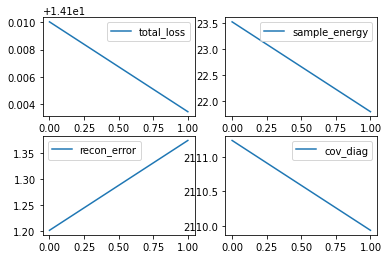

 20%|█▉        | 22/112 [00:02<00:11,  7.67it/s]

======================= z ==================
 tensor([[-1.0949e-02, -3.4733e-03, -7.1062e-03,  ..., -4.3802e-03,
          1.0933e+00, -2.0197e-02],
        [ 8.9145e-01,  4.4293e-01,  1.5292e-01,  ..., -2.1126e-03,
          9.1701e-01,  4.0049e-01],
        [ 1.5722e+00, -9.2357e-03, -9.0483e-03,  ..., -3.4275e-03,
          1.0827e+00, -1.2036e-01],
        ...,
        [ 1.0220e+00,  2.0546e-01,  3.0274e-01,  ..., -3.9606e-03,
          9.1347e-01,  4.0818e-01],
        [-4.0741e-03, -5.5066e-03,  8.3024e-01,  ...,  1.1722e+00,
          1.0522e+00,  9.8510e-02],
        [-1.3874e-03,  7.9495e-01,  4.6162e-01,  ...,  7.7564e-01,
          1.1844e+00, -1.7531e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.0949e-02, -3.4733e-03, -7.1062e-03,  ..., -2.3120e-03,
          1.5385e+00, -4.3802e-03],
        [ 8.9145e-01,  4.4293e-01,  1.5292e-01,  ..., -9.2712e-03,
         -5.8933e-03, -2.1126e-03],
        [ 1.5722e+00, -9.23

 23%|██▎       | 26/112 [00:02<00:08, 10.61it/s]

======================= z ==================
 tensor([[-1.0161e-02,  9.1625e-01, -1.4190e-02,  ...,  1.2573e-01,
          1.0423e+00, -6.7348e-03],
        [ 7.4956e-01,  5.1718e-01,  4.4496e-01,  ..., -9.7537e-04,
          8.7448e-01,  5.1452e-01],
        [ 9.5202e-01,  7.3769e-01, -5.8260e-03,  ..., -1.2017e-03,
          1.1860e+00, -4.7116e-01],
        ...,
        [ 4.0528e-02, -1.7535e-02, -1.7014e-02,  ...,  8.5403e-01,
          1.0056e+00,  1.8831e-01],
        [ 4.5021e-01,  5.6372e-01,  1.7331e-01,  ..., -3.7779e-03,
          1.1080e+00, -1.5548e-01],
        [-1.1336e-02, -4.7356e-03,  1.7785e+00,  ...,  8.3385e-01,
          1.0343e+00,  1.2502e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.0161e-02,  9.1625e-01, -1.4190e-02,  ...,  1.5263e-01,
          4.9047e-01,  1.2573e-01],
        [ 7.4956e-01,  5.1718e-01,  4.4496e-01,  ..., -9.3525e-03,
         -4.1303e-03, -9.7537e-04],
        [ 9.5202e-01,  7.37

 26%|██▌       | 29/112 [00:02<00:06, 13.11it/s]

tensor([-0.0674,  0.0308,  0.2950,  ..., -0.2067,  0.3215, -0.0253],
       device='cuda:0', grad_fn=<SumBackward1>)
======================= euclidean ==================
 tensor([1.0919, 1.1811, 0.9559,  ..., 1.1115, 0.9995, 1.1614], device='cuda:0',
       grad_fn=<DivBackward0>)
xxxx
 tensor([[ 0.4458,  0.2425, -0.2109,  ...,  0.0716, -0.2407, -0.4523],
        [ 0.6428,  0.0551,  0.0795,  ...,  0.0128, -0.3462, -0.1969],
        [ 0.6828, -0.3975,  0.3064,  ..., -0.0358, -0.3208, -1.5717],
        ...,
        [-0.0574,  0.1541,  1.0556,  ..., -0.4708, -0.3010,  1.2688],
        [ 0.0696, -0.4083,  0.9772,  ..., -0.0111, -0.1616,  0.8230],
        [ 0.5539, -0.3538,  0.5329,  ...,  0.0718,  0.0841, -0.3406]],
       device='cuda:0') 

======================= z ==================
 tensor([[-8.6812e-03,  1.0096e+00,  1.1989e+00,  ..., -1.6209e-02,
          9.1382e-01,  4.1848e-01],
        [ 6.9333e-01, -2.4014e-02,  1.4858e-01,  ...,  7.3943e-01,
          1.1027e+00,  1.1185e-02],


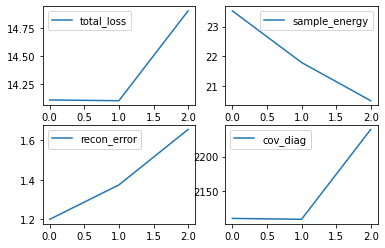

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 30%|███       | 34/112 [00:03<00:08,  8.71it/s]

======================= z ==================
 tensor([[-0.0023,  0.5507,  0.0938,  ...,  0.6777,  1.0341,  0.2015],
        [ 0.2509, -0.0184, -0.0037,  ...,  1.2211,  0.9413,  0.3667],
        [-0.0159, -0.0102,  1.8043,  ...,  0.9640,  1.2274, -0.2239],
        ...,
        [ 1.5961, -0.0125, -0.0031,  ...,  1.3779,  0.9766,  0.2219],
        [-0.0023,  0.2777,  0.1351,  ..., -0.0080,  0.9585,  0.2873],
        [ 0.8962, -0.0243, -0.0067,  ...,  1.9764,  1.0895, -0.0280]],
       device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-2.3033e-03,  5.5074e-01,  9.3764e-02,  ...,  2.9402e-01,
          1.1150e+00,  6.7769e-01],
        [ 2.5091e-01, -1.8398e-02, -3.7189e-03,  ..., -1.7677e-03,
          1.4191e+00,  1.2211e+00],
        [-1.5866e-02, -1.0167e-02,  1.8043e+00,  ...,  4.6782e-01,
         -2.3872e-03,  9.6396e-01],
        ...,
        [ 1.5961e+00, -1.2476e-02, -3.0644e-03,  ...,  9.9484e-02,
          4.1772e-01,  1.3779e+00],

 35%|███▍      | 39/112 [00:04<00:06, 10.45it/s]

======================= z ==================
 tensor([[ 0.7238, -0.0026, -0.0067,  ..., -0.0100,  1.0335,  0.0967],
        [ 2.0821, -0.0143, -0.0071,  ...,  2.0481,  1.0492,  0.0356],
        [ 0.3166,  0.6080, -0.0032,  ..., -0.0076,  1.1994, -0.3851],
        ...,
        [ 0.6115, -0.0041, -0.0084,  ..., -0.0039,  1.3109, -0.2672],
        [ 1.0763, -0.0077, -0.0081,  ...,  0.2620,  1.2402, -0.4181],
        [ 0.8389, -0.0136,  0.7003,  ...,  1.6531,  0.9809,  0.2253]],
       device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 7.2380e-01, -2.5862e-03, -6.6858e-03,  ..., -9.2847e-03,
         -7.3405e-03, -1.0015e-02],
        [ 2.0821e+00, -1.4275e-02, -7.0808e-03,  ...,  4.4164e-01,
          1.2365e+00,  2.0481e+00],
        [ 3.1664e-01,  6.0800e-01, -3.1882e-03,  ..., -8.3903e-03,
          4.3981e-05, -7.5763e-03],
        ...,
        [ 6.1151e-01, -4.1179e-03, -8.4164e-03,  ..., -1.7565e-03,
         -4.8740e-03, -3.9180e-03],

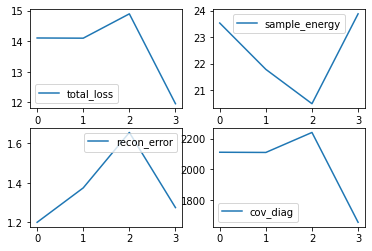

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 39%|███▉      | 44/112 [00:04<00:07,  8.88it/s]

======================= z ==================
 tensor([[-1.8912e-02,  7.4356e-01, -6.8143e-03,  ..., -1.6041e-03,
          9.8922e-01,  1.7330e-01],
        [ 4.1961e-01, -9.4053e-03,  4.9641e-01,  ...,  6.6471e-01,
          1.0152e+00,  1.9881e-01],
        [ 5.2856e-01, -1.2960e-03, -6.2775e-03,  ..., -1.0466e-02,
          1.1490e+00,  4.6934e-02],
        ...,
        [ 1.3324e+00,  2.7087e-01, -1.1041e-02,  ..., -7.2771e-05,
          1.2123e+00, -2.7917e-01],
        [ 2.4095e-01,  6.4557e-01,  4.3907e-01,  ...,  3.9795e-01,
          1.0380e+00, -2.1229e-02],
        [-2.4685e-04,  5.5751e-01,  1.8632e+00,  ...,  4.0718e-01,
          1.1110e+00, -2.7556e-02]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.8912e-02,  7.4356e-01, -6.8143e-03,  ...,  9.3608e-01,
         -8.1028e-03, -1.6041e-03],
        [ 4.1961e-01, -9.4053e-03,  4.9641e-01,  ...,  3.9552e-02,
          1.1667e+00,  6.6471e-01],
        [ 5.2856e-01, -1.29

 41%|████      | 46/112 [00:05<00:06, 10.20it/s]

tensor([[ 1.0892, -0.0583, -1.0393,  ..., -0.1698, -0.3544,  1.3077],
        [-0.3567, -0.5576,  0.8373,  ...,  0.4365, -0.1408,  1.5884],
        [-0.2950,  0.4918,  0.1895,  ..., -0.0026, -0.1390,  1.0845],
        ...,
        [-0.4493,  0.5099,  1.8726,  ...,  0.2779, -0.2174, -0.3727],
        [ 0.5532,  0.1657,  1.0952,  ...,  0.1148, -0.3229, -0.7805],
        [-0.2988,  0.3657,  0.8813,  ...,  0.4116, -0.2820, -1.3255]],
       device='cuda:0') 

======================= z ==================
 tensor([[ 4.1566e-01,  3.2134e-01, -3.3646e-03,  ...,  1.2174e-01,
          1.4827e+00, -4.6969e-01],
        [ 7.5589e-01, -2.5634e-03, -1.0061e-02,  ..., -7.7212e-03,
          1.4772e+00, -3.1269e-01],
        [ 3.6657e-01, -3.0841e-03, -9.2465e-03,  ..., -5.8813e-03,
          9.9898e-01,  1.4679e-01],
        ...,
        [-3.8689e-04,  2.1012e-01,  2.7903e-01,  ..., -1.6131e-02,
          9.7495e-01,  2.3460e-01],
        [ 5.8439e-01, -3.9646e-04, -5.7846e-03,  ..., -1.1934e-02,
  

 43%|████▎     | 48/112 [00:05<00:05, 10.77it/s]

tensor([[-5.6665e-01,  2.7742e-01,  8.0025e-01,  ..., -2.9383e-01,
         -4.3722e-02,  1.2228e+00],
        [-2.6291e-03,  5.3299e-01,  6.5649e-01,  ...,  5.4616e-01,
         -3.5157e-01,  1.1534e+00],
        [ 9.4782e-01, -4.0593e-01,  8.7843e-02,  ...,  1.6370e-02,
         -2.3619e-01,  5.9027e-01],
        ...,
        [ 1.1954e+00, -7.8110e-01, -7.8555e-01,  ..., -1.2923e-01,
         -3.0035e-01,  6.6728e-01],
        [ 3.2366e-01, -2.7308e+00, -1.6888e+00,  ...,  2.8060e-01,
          3.0569e+00,  1.3806e+00],
        [ 6.4586e-01,  1.0253e-01, -2.7348e-03,  ...,  3.0394e-02,
         -3.5366e-01, -4.8812e-01]], device='cuda:0') 

======================= z ==================
 tensor([[-3.7102e-03,  1.6665e-02, -6.7257e-03,  ..., -2.8473e-04,
          8.9742e-01,  4.5023e-01],
        [-7.4093e-03,  1.0202e+00,  2.5518e-01,  ..., -9.8157e-03,
          1.1387e+00, -2.6851e-01],
        [ 7.3567e-02,  1.1703e-01,  2.2297e-01,  ...,  8.2035e-02,
          9.7319e-01,  2.3262e

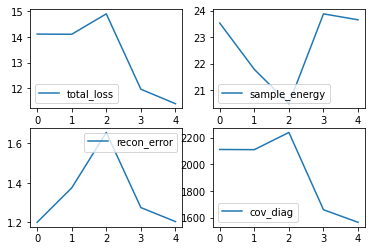

 45%|████▍     | 50/112 [00:05<00:09,  6.25it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


======================= z ==================
 tensor([[-1.8417e-03,  1.9643e-01, -3.3622e-03,  ..., -5.3791e-03,
          1.0245e+00,  6.9843e-02],
        [-7.9418e-03, -1.2328e-02,  4.7894e-01,  ...,  2.1685e+00,
          9.8739e-01,  3.5821e-01],
        [ 9.1570e-01, -5.7323e-04,  6.3090e-01,  ...,  2.8060e-02,
          1.1433e+00, -5.6979e-02],
        ...,
        [-6.3515e-04, -7.8438e-03, -6.8793e-03,  ..., -5.2067e-03,
          1.1822e+00, -7.8261e-02],
        [ 8.3289e-01,  8.9228e-01,  1.1736e+00,  ..., -9.5548e-03,
          1.3401e+00, -4.8807e-01],
        [-1.2979e-03,  8.8817e-01,  2.7065e-01,  ...,  8.9719e-02,
          9.4054e-01,  3.3994e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.8417e-03,  1.9643e-01, -3.3622e-03,  ...,  3.1686e-01,
         -2.8897e-03, -5.3791e-03],
        [-7.9418e-03, -1.2328e-02,  4.7894e-01,  ..., -4.4762e-03,
          1.4663e+00,  2.1685e+00],
        [ 9.1570e-01, -5.73

 48%|████▊     | 54/112 [00:06<00:07,  7.87it/s]

======================= z ==================
 tensor([[ 2.0761e+00,  3.2407e+00, -5.2605e-03,  ..., -2.4334e-02,
          1.0197e+00,  5.4161e-02],
        [-1.1175e-03,  5.1029e-01, -6.5247e-03,  ..., -4.4521e-03,
          1.0857e+00,  1.5792e-02],
        [ 2.5998e-03,  3.3109e-01, -4.3990e-03,  ...,  7.5138e-01,
          1.1707e+00, -6.4063e-02],
        ...,
        [ 3.1659e-02, -5.7790e-03, -3.8369e-03,  ..., -1.3031e-03,
          1.0670e+00,  3.0608e-02],
        [-4.9722e-03,  1.9897e-01,  9.6743e-01,  ..., -4.1673e-03,
          1.1859e+00, -3.3739e-02],
        [ 1.0283e+00,  5.9171e-02,  8.9673e-02,  ..., -6.3630e-03,
          9.2639e-01,  3.7822e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 2.0761e+00,  3.2407e+00, -5.2605e-03,  ...,  1.9889e+00,
          4.2018e-01, -2.4334e-02],
        [-1.1175e-03,  5.1029e-01, -6.5247e-03,  ..., -1.5745e-03,
         -8.2143e-03, -4.4521e-03],
        [ 2.5998e-03,  3.31

 52%|█████▏    | 58/112 [00:06<00:04, 11.04it/s]

======================= z ==================
 tensor([[ 1.8369e-01,  2.3117e-01,  1.8540e-01,  ..., -6.6561e-03,
          1.4256e+00, -5.3424e-01],
        [-4.5519e-03, -1.9494e-03, -1.1445e-02,  ...,  6.6686e-01,
          1.1845e+00, -3.1811e-03],
        [-2.5156e-03, -2.1961e-02,  1.5176e-01,  ...,  1.5118e+00,
          8.7979e-01,  4.7537e-01],
        ...,
        [-4.8429e-03,  7.2856e-01, -2.4165e-03,  ..., -3.9327e-03,
          1.1200e+00, -3.2605e-02],
        [ 1.3791e-01, -6.0713e-03, -2.2930e-03,  ..., -5.1713e-03,
          9.4086e-01,  3.3934e-01],
        [-2.7998e-04, -2.1259e-03, -3.5996e-03,  ..., -3.3178e-03,
          1.0397e+00,  1.0128e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 1.8369e-01,  2.3117e-01,  1.8540e-01,  ..., -1.0551e-02,
          1.0766e-01, -6.6561e-03],
        [-4.5519e-03, -1.9494e-03, -1.1445e-02,  ...,  1.6135e-01,
          4.8378e-01,  6.6686e-01],
        [-2.5156e-03, -2.19

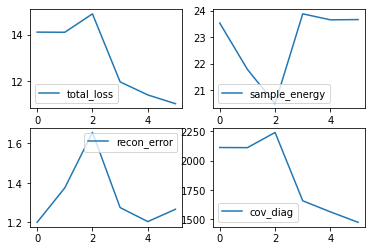

 55%|█████▌    | 62/112 [00:07<00:06,  8.04it/s]

======================= z ==================
 tensor([[-5.4186e-03,  9.1304e-01,  7.6529e-03,  ..., -1.6727e-03,
          1.6510e+00, -6.4314e-01],
        [-8.5892e-03,  5.9628e-01, -8.2176e-03,  ..., -7.5625e-03,
          9.9256e-01,  1.9154e-01],
        [ 3.6135e-01, -2.9649e-03, -6.0523e-03,  ..., -1.3285e-03,
          1.0869e+00,  1.4604e-01],
        ...,
        [ 5.8198e-01,  4.1011e-01,  2.8682e-01,  ..., -2.1567e-03,
          1.1487e+00, -1.8022e-01],
        [-1.5561e-02,  8.3240e-01, -1.5895e-02,  ..., -6.0300e-03,
          1.1971e+00, -4.8233e-01],
        [ 2.5809e-01,  1.8032e-01, -3.1696e-03,  ..., -6.8709e-03,
          1.1113e+00,  1.9480e-02]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-0.0054,  0.9130,  0.0077,  ..., -0.0041,  0.4740, -0.0017],
        [-0.0086,  0.5963, -0.0082,  ...,  0.2558, -0.0137, -0.0076],
        [ 0.3614, -0.0030, -0.0061,  ..., -0.0090,  0.8298, -0.0013],
        ...,
        [ 

 60%|█████▉    | 67/112 [00:07<00:04, 11.14it/s]

tensor([[ 4.3419e-01, -4.7655e-01, -5.6650e-01,  ...,  1.0630e-01,
         -1.5768e-02, -2.4772e-01],
        [-3.5209e-01, -3.2900e-01,  1.4475e-01,  ..., -5.0721e-01,
         -2.6477e-01, -6.3723e-01],
        [ 3.4772e-01, -2.3729e-01, -3.4925e-01,  ...,  1.0389e-01,
         -1.2257e-01, -2.8436e-01],
        ...,
        [ 3.6964e+00,  1.3790e-01,  2.1231e-01,  ...,  6.1246e-02,
          4.7401e-02,  4.8618e-01],
        [-7.3923e-02, -2.1001e-01,  1.3450e-01,  ..., -4.5551e-01,
         -5.1123e-01, -1.7375e-01],
        [-5.1811e-04, -3.5826e-01, -2.7322e-01,  ..., -1.5673e-01,
         -1.2083e-01, -1.9605e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)
======================= cosines ==================
 tensor([-0.0393,  0.0137,  0.7326,  ...,  0.2623,  0.3391,  0.0824],
       device='cuda:0', grad_fn=<SumBackward1>)
======================= euclidean ==================
 tensor([1.1195, 1.1477, 0.7144,  ..., 0.9856, 0.9806, 1.0263], device='cuda:0',
       grad_fn=<DivBac

 62%|██████▏   | 69/112 [00:07<00:03, 12.50it/s]

tensor([[-5.5424e-03,  5.6311e-01, -3.4495e-03,  ..., -4.5758e-03,
          1.0223e+00,  1.0269e-01],
        [ 3.7828e-01, -1.7109e-02,  1.7127e+00,  ...,  9.5199e-02,
          1.1612e+00,  4.9162e-02],
        [ 4.9934e-01, -1.2468e-02, -2.5839e-03,  ..., -9.3330e-04,
          1.0544e+00,  4.9412e-02],
        ...,
        [-2.0901e-03,  1.7472e-01,  1.2031e+00,  ..., -5.8587e-03,
          1.0768e+00,  4.2630e-02],
        [ 2.6116e-01, -1.2803e-02, -5.7063e-03,  ..., -6.8153e-03,
          1.0087e+00,  1.7829e-01],
        [-6.1226e-03, -6.0555e-03,  1.1989e+00,  ...,  1.2137e+00,
          8.5730e-01,  5.1904e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-5.5424e-03,  5.6311e-01, -3.4495e-03,  ..., -5.2304e-03,
          2.6939e-02, -4.5758e-03],
        [ 3.7828e-01, -1.7109e-02,  1.7127e+00,  ...,  4.9769e-01,
         -7.5413e-03,  9.5199e-02],
        [ 4.9934e-01, -1.2468e-02, -2.5839e-03,  ...,  6.9023e-01,
      

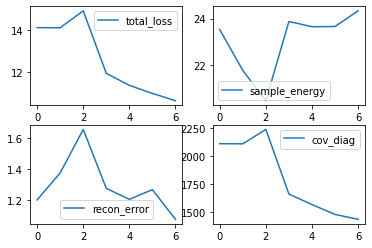

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 65%|██████▌   | 73/112 [00:08<00:05,  6.74it/s]

======================= z ==================
 tensor([[-0.0020,  0.9687, -0.0074,  ..., -0.0060,  1.1410, -0.1246],
        [ 0.8149, -0.0291,  0.1977,  ...,  0.6304,  0.9961,  0.2395],
        [ 0.8512,  0.0947,  0.1156,  ..., -0.0076,  0.8739,  0.5122],
        ...,
        [ 0.3841,  1.1875, -0.0051,  ..., -0.0085,  0.9489,  0.3166],
        [ 0.0417, -0.0052,  0.9622,  ...,  0.6715,  0.8593,  0.5571],
        [-0.0071,  1.2085, -0.0103,  ...,  0.1557,  1.0607,  0.1572]],
       device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.9679e-03,  9.6867e-01, -7.4073e-03,  ..., -2.7028e-03,
         -1.1020e-02, -5.9511e-03],
        [ 8.1487e-01, -2.9067e-02,  1.9769e-01,  ..., -9.1353e-03,
          6.1966e-01,  6.3044e-01],
        [ 8.5120e-01,  9.4713e-02,  1.1563e-01,  ..., -1.5734e-03,
         -1.1004e-02, -7.5615e-03],
        ...,
        [ 3.8410e-01,  1.1875e+00, -5.1342e-03,  ..., -1.4682e-02,
          1.3607e+00, -8.4752e-03],

 69%|██████▉   | 77/112 [00:08<00:03,  9.86it/s]

======================= z ==================
 tensor([[ 1.5062e+00, -1.4162e-02, -8.2869e-03,  ...,  2.5460e-01,
          9.9286e-01,  2.2482e-01],
        [-5.1336e-03, -8.9327e-03,  4.3580e-01,  ...,  2.0943e+00,
          7.6190e-01,  6.5433e-01],
        [-9.2652e-03, -3.4885e-03,  7.9620e-02,  ...,  1.5435e-01,
          1.0533e+00, -9.1032e-02],
        ...,
        [ 3.9540e-01,  3.9895e-01, -1.2519e-02,  ...,  2.6296e-01,
          1.6073e+00, -6.1695e-01],
        [-6.7552e-03, -1.0799e-03,  5.3574e-01,  ..., -3.9181e-03,
          1.0900e+00,  6.7802e-02],
        [ 7.2639e-01,  9.5267e-01, -1.6971e-03,  ..., -1.0929e-02,
          1.2360e+00, -2.1188e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 1.5062e+00, -1.4162e-02, -8.2869e-03,  ..., -3.8799e-03,
         -2.5377e-03,  2.5460e-01],
        [-5.1336e-03, -8.9327e-03,  4.3580e-01,  ..., -5.9206e-03,
          1.5225e+00,  2.0943e+00],
        [-9.2652e-03, -3.48

 71%|███████   | 79/112 [00:08<00:02, 11.56it/s]

======================= z ==================
 tensor([[ 1.5240e+00, -1.2398e-02, -1.1983e-02,  ...,  7.6145e-01,
          1.0089e+00,  1.6278e-01],
        [-1.4178e-03, -8.6433e-03, -5.5273e-03,  ...,  7.6421e-02,
          1.0079e+00,  1.6026e-01],
        [ 2.5192e-01, -4.5081e-03,  5.5336e-01,  ..., -5.0352e-03,
          1.2575e+00, -2.4212e-01],
        ...,
        [ 1.5098e-01, -1.0816e-03, -8.6055e-03,  ..., -2.2051e-03,
          1.1415e+00, -2.7641e-02],
        [ 3.1123e-01, -2.0994e-03, -3.5959e-03,  ..., -6.9950e-03,
          1.1380e+00,  8.7732e-02],
        [-1.1927e-03, -5.5165e-03,  1.1757e-01,  ..., -3.4945e-03,
          1.0181e+00,  1.7250e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 1.5240e+00, -1.2398e-02, -1.1983e-02,  ..., -1.4152e-03,
          1.4040e-01,  7.6145e-01],
        [-1.4178e-03, -8.6433e-03, -5.5273e-03,  ..., -1.5635e-03,
          1.2495e-02,  7.6421e-02],
        [ 2.5192e-01, -4.50

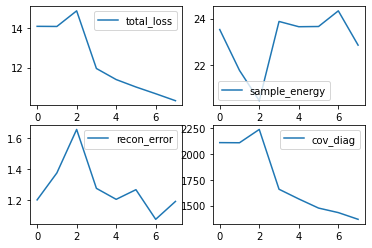

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 74%|███████▍  | 83/112 [00:09<00:03,  8.11it/s]

======================= z ==================
 tensor([[-5.7968e-03,  1.0173e-01, -6.0823e-03,  ...,  1.3133e+00,
          1.5456e+00, -2.6103e-01],
        [ 1.5889e-01, -1.6770e-02,  1.3285e+00,  ...,  1.2214e+00,
          8.7312e-01,  5.3202e-01],
        [ 6.7552e-01,  1.3002e-01, -3.7674e-03,  ..., -5.8993e-03,
          9.5347e-01,  3.3951e-01],
        ...,
        [-6.0827e-03,  1.0695e+00,  1.2516e+00,  ..., -1.0044e-02,
          1.0290e+00,  1.2587e-01],
        [ 1.9812e+00, -8.0131e-03,  5.1532e-01,  ...,  2.5052e+00,
          1.5331e+00, -4.6952e-01],
        [ 1.1212e+00, -6.4553e-03, -1.6394e-04,  ...,  1.6233e-01,
          1.2642e+00, -2.5783e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-5.7968e-03,  1.0173e-01, -6.0823e-03,  ..., -8.1760e-04,
          1.5034e+00,  1.3133e+00],
        [ 1.5889e-01, -1.6770e-02,  1.3285e+00,  ...,  5.7179e-01,
          3.5408e-01,  1.2214e+00],
        [ 6.7552e-01,  1.30

 78%|███████▊  | 87/112 [00:09<00:02, 10.89it/s]

======================= z ==================
 tensor([[-3.9510e-02,  4.0291e+00,  4.0632e+00,  ..., -6.4055e-04,
          1.1504e+00, -9.4190e-02],
        [ 4.0536e-01,  1.0497e+00, -1.1099e-02,  ...,  1.3728e+00,
          1.5884e+00, -4.9623e-01],
        [ 5.7279e-01,  3.7984e-01, -8.6391e-03,  ..., -7.1696e-03,
          1.3861e+00, -4.1680e-01],
        ...,
        [ 1.7969e-01,  9.3046e-01, -2.4713e-03,  ..., -1.2799e-02,
          9.8670e-01,  2.2045e-01],
        [ 4.8835e-01, -1.9696e-03, -1.3539e-02,  ..., -6.6896e-03,
          1.5173e+00, -4.4660e-01],
        [ 9.4100e-01, -1.0649e-02, -7.2129e-03,  ..., -1.1843e-02,
          1.1584e+00, -2.7039e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-3.9510e-02,  4.0291e+00,  4.0632e+00,  ...,  3.8396e+00,
          2.9073e+00, -6.4055e-04],
        [ 4.0536e-01,  1.0497e+00, -1.1099e-02,  ...,  1.3582e+00,
          7.0979e-01,  1.3728e+00],
        [ 5.7279e-01,  3.79

 79%|███████▉  | 89/112 [00:10<00:01, 12.33it/s]

======================= z ==================
 tensor([[ 0.2374,  1.2345, -0.0082,  ...,  1.0542,  1.3655, -0.3641],
        [-0.0071,  0.5966,  0.2336,  ..., -0.0074,  1.2757, -0.1284],
        [ 0.1732, -0.0083, -0.0069,  ...,  0.1818,  1.2399, -0.2110],
        ...,
        [ 1.1948,  1.0594, -0.0083,  ...,  2.3123,  1.4011, -0.3483],
        [ 0.1614, -0.0106,  0.6215,  ...,  0.0920,  1.0246,  0.0801],
        [ 0.0348, -0.0037,  0.2423,  ...,  0.2804,  1.3314, -0.2640]],
       device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 2.3742e-01,  1.2345e+00, -8.1877e-03,  ...,  3.6584e-01,
          6.0914e-01,  1.0542e+00],
        [-7.1082e-03,  5.9659e-01,  2.3363e-01,  ..., -5.0286e-03,
          1.2697e-01, -7.4305e-03],
        [ 1.7320e-01, -8.3393e-03, -6.9475e-03,  ..., -6.7216e-03,
         -4.3077e-03,  1.8184e-01],
        ...,
        [ 1.1948e+00,  1.0594e+00, -8.2565e-03,  ...,  1.9036e+00,
          7.3445e-01,  2.3123e+00],

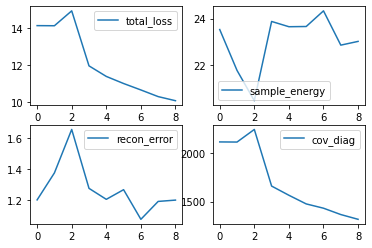

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 83%|████████▎ | 93/112 [00:10<00:02,  7.10it/s]

======================= z ==================
 tensor([[-8.0638e-03, -3.5939e-03,  4.9282e-01,  ...,  7.1845e-01,
          1.4054e+00,  2.9381e-02],
        [-2.0793e-04,  6.9537e-01,  2.5143e-02,  ..., -1.2701e-02,
          1.3325e+00, -3.3448e-01],
        [-5.9986e-03,  9.6534e-01, -6.1277e-04,  ..., -7.5960e-03,
          1.2702e+00, -2.5562e-01],
        ...,
        [-9.2092e-03, -7.2950e-03,  5.8369e-01,  ...,  2.0669e+00,
          1.1447e+00,  2.8812e-01],
        [ 1.2800e+00, -2.3297e-03,  2.3355e+00,  ...,  4.3704e-01,
          9.9046e-01,  1.8522e-01],
        [-4.9489e-03,  8.4660e-01, -7.7956e-03,  ...,  7.2912e-02,
          1.0939e+00,  1.4532e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-8.0638e-03, -3.5939e-03,  4.9282e-01,  ..., -2.6760e-03,
          1.1613e+00,  7.1845e-01],
        [-2.0793e-04,  6.9537e-01,  2.5143e-02,  ..., -1.0931e-02,
          3.9577e-02, -1.2701e-02],
        [-5.9986e-03,  9.65

 87%|████████▋ | 97/112 [00:11<00:01,  9.66it/s]

======================= z ==================
 tensor([[-1.8084e-02,  1.4832e+00, -7.5427e-03,  ...,  2.8510e-01,
          9.7438e-01,  2.2872e-01],
        [-1.8855e-02,  1.0040e+00, -7.4114e-03,  ..., -3.6304e-03,
          1.1792e+00, -2.0620e-01],
        [-3.7918e-03, -2.7762e-03, -7.2405e-03,  ..., -2.9309e-03,
          9.7676e-01,  2.7783e-01],
        ...,
        [-5.0081e-03, -1.1395e-03, -9.6217e-03,  ..., -2.5326e-03,
          1.0620e+00,  1.1086e-01],
        [ 8.7134e-01, -3.7995e-03, -7.4111e-04,  ..., -2.2952e-03,
          9.0115e-01,  4.3443e-01],
        [-3.8288e-04, -6.2564e-03, -3.4211e-03,  ..., -4.5907e-03,
          1.0134e+00,  1.6921e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-1.8084e-02,  1.4832e+00, -7.5427e-03,  ...,  1.1536e+00,
         -3.5189e-03,  2.8510e-01],
        [-1.8855e-02,  1.0040e+00, -7.4114e-03,  ..., -6.1106e-03,
          1.7964e+00, -3.6304e-03],
        [-3.7918e-03, -2.77

 88%|████████▊ | 99/112 [00:11<00:01, 11.29it/s]

======================= z ==================
 tensor([[ 7.5932e-01,  6.7909e-02, -2.2365e-03,  ...,  8.1190e-01,
          1.0213e+00,  9.2260e-02],
        [ 1.9447e-01, -8.1342e-03, -8.8798e-04,  ..., -1.6344e-02,
          8.8134e-01,  4.8996e-01],
        [ 3.4872e-01, -9.9577e-05, -1.1162e-02,  ..., -1.0421e-02,
          9.7175e-01,  2.5350e-01],
        ...,
        [-4.9879e-03, -2.0322e-02,  3.3798e-01,  ...,  1.9236e+00,
          7.8346e-01,  6.4102e-01],
        [ 8.7014e-01,  4.1922e-01,  4.7565e-01,  ..., -1.0972e-02,
          1.0125e+00,  7.4561e-02],
        [-1.5809e-03, -1.0796e-02, -9.5109e-03,  ..., -3.5773e-03,
          1.1587e+00,  1.6509e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 7.5932e-01,  6.7909e-02, -2.2365e-03,  ..., -8.9599e-03,
          5.9328e-01,  8.1190e-01],
        [ 1.9447e-01, -8.1342e-03, -8.8798e-04,  ..., -2.6267e-03,
         -7.9590e-03, -1.6344e-02],
        [ 3.4872e-01, -9.95

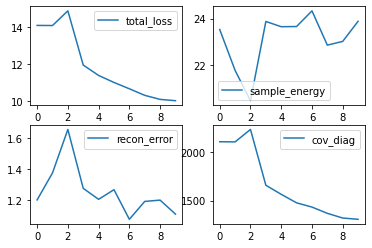

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
 92%|█████████▏| 103/112 [00:12<00:01,  8.22it/s]

======================= z ==================
 tensor([[ 9.4863e-01, -2.0127e-02, -9.8212e-03,  ...,  5.9248e-01,
          1.1327e+00,  1.1108e-01],
        [ 1.6555e-01, -8.4004e-03,  4.2482e-01,  ..., -2.2498e-03,
          1.0228e+00,  2.5465e-01],
        [ 4.3410e-01,  1.2099e+00,  4.0568e-02,  ...,  1.6040e+00,
          9.9564e-01,  1.6041e-01],
        ...,
        [-1.7648e-02,  1.3643e+00, -6.9223e-03,  ..., -4.4945e-04,
          1.1232e+00, -1.8772e-01],
        [-5.8087e-03, -6.8093e-03, -1.0892e-03,  ...,  7.3413e-01,
          1.4607e+00, -3.2296e-01],
        [ 4.4279e-01, -5.0813e-05, -3.5875e-03,  ..., -8.9502e-03,
          8.9636e-01,  4.4897e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 9.4863e-01, -2.0127e-02, -9.8212e-03,  ..., -1.9834e-03,
          5.2336e-01,  5.9248e-01],
        [ 1.6555e-01, -8.4004e-03,  4.2482e-01,  ..., -3.1283e-03,
         -1.8185e-03, -2.2498e-03],
        [ 4.3410e-01,  1.20

 94%|█████████▍| 105/112 [00:12<00:00,  9.81it/s]

======================= z ==================
 tensor([[ 1.8882e-01,  4.2034e-01, -1.8083e-03,  ..., -4.1741e-03,
          1.3724e+00, -3.7712e-01],
        [-3.5732e-04, -1.4959e-02,  8.0368e-01,  ...,  1.7667e+00,
          8.4150e-01,  5.6551e-01],
        [ 1.7759e+00, -5.3257e-03, -3.6068e-03,  ..., -1.7752e-03,
          9.7949e-01,  2.0159e-01],
        ...,
        [ 3.0242e-02,  3.2066e-02, -9.3720e-03,  ...,  2.7238e-02,
          1.7056e+00, -1.4581e-01],
        [ 4.1527e-01,  1.3749e-01, -9.3790e-04,  ..., -8.3189e-03,
          1.1677e+00, -8.0413e-03],
        [ 3.6902e-01, -7.9607e-03,  7.5324e-02,  ...,  2.0940e-01,
          1.3950e+00, -2.7263e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 1.8882e-01,  4.2034e-01, -1.8083e-03,  ..., -5.9157e-03,
         -1.7673e-03, -4.1741e-03],
        [-3.5732e-04, -1.4959e-02,  8.0368e-01,  ...,  7.5800e-01,
          3.1646e-01,  1.7667e+00],
        [ 1.7759e+00, -5.32

 97%|█████████▋| 109/112 [00:12<00:00,  8.63it/s]

======================= z ==================
 tensor([[-7.8171e-03,  3.8153e-01, -5.0292e-04,  ...,  2.1541e+00,
          1.9441e+00, -5.9516e-01],
        [-3.8174e-03, -1.1551e-02, -2.5499e-03,  ..., -3.9836e-03,
          9.7443e-01,  2.3088e-01],
        [-6.2452e-03, -3.4319e-03, -5.1354e-03,  ..., -6.1055e-03,
          1.0683e+00,  1.2141e-01],
        ...,
        [-1.5743e-02,  1.5595e-01,  2.1499e-01,  ...,  3.5262e-01,
          9.3884e-01,  3.6643e-01],
        [-1.8753e-03, -6.3424e-03, -1.9968e-03,  ..., -3.7607e-03,
          9.4653e-01,  3.2486e-01],
        [-1.2965e-02,  1.7393e+00, -1.7478e-02,  ...,  4.5741e-01,
          1.0592e+00, -1.0740e-01]], device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[-7.8171e-03,  3.8153e-01, -5.0292e-04,  ..., -2.0257e-03,
          2.2216e+00,  2.1541e+00],
        [-3.8174e-03, -1.1551e-02, -2.5499e-03,  ...,  1.2414e-01,
         -7.9181e-03, -3.9836e-03],
        [-6.2452e-03, -3.43

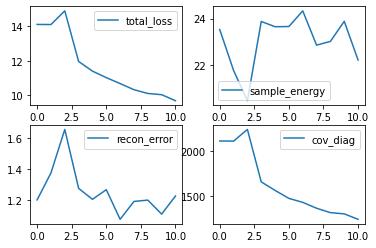

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
100%|██████████| 112/112 [00:13<00:00,  8.37it/s]


======================= z ==================
 tensor([[ 0.3963, -0.0050, -0.0081,  ..., -0.0068,  1.1534,  0.0651],
        [ 0.1001,  0.3254, -0.0105,  ..., -0.0043,  1.0870, -0.0142],
        [-0.0021, -0.0027, -0.0083,  ...,  0.2254,  1.1157, -0.0057],
        ...,
        [ 0.4579, -0.0035, -0.0104,  ..., -0.0084,  1.6091, -0.4028],
        [ 0.2846, -0.0192,  0.7147,  ...,  1.3104,  0.9107,  0.4226],
        [-0.0087, -0.0162,  1.5913,  ...,  0.5289,  0.9264,  0.4005]],
       device='cuda:0', grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[ 0.3963, -0.0050, -0.0081,  ..., -0.0042, -0.0059, -0.0068],
        [ 0.1001,  0.3254, -0.0105,  ..., -0.0086, -0.0132, -0.0043],
        [-0.0021, -0.0027, -0.0083,  ...,  0.5661, -0.0074,  0.2254],
        ...,
        [ 0.4579, -0.0035, -0.0104,  ...,  0.4308, -0.0058, -0.0084],
        [ 0.2846, -0.0192,  0.7147,  ..., -0.0095,  1.6334,  1.3104],
        [-0.0087, -0.0162,  1.5913,  ...,  0.1604,  0.6223,  

  0%|          | 0/56 [00:00<?, ?it/s]

======================= z ==================
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<CatBackward0>)
======================= enc ==================
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)
======================= dec ==================
 tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  

  0%|          | 0/56 [02:00<?, ?it/s]


RuntimeError: ignored

In [12]:
import os
import argparse
# from solver import Solver
# from data_loader import get_loader
from torch.backends import cudnn
# from utils import *

def str2bool(v):
    return v.lower() in ('true')

def main(config):
    # For fast training
    cudnn.benchmark = True

    # Create directories if not exist
    # mkdir(config.log_path)
    # mkdir(config.model_save_path)
    wandb.init()
    data_loader, data_loader_v, data_loader_test = get_loader(config.data_path, batch_size=config.batch_size, mode=config.mode)
    
    import torch
    USE_CUDA = torch.cuda.is_available()
    device = torch.device('cuda:0' if USE_CUDA else 'cpu')

    # Solver
    solver = Solver(device, data_loader, data_loader_v, data_loader_test, vars(config))

    if config.mode == 'train' : 
      solver.train()
      return solver
    elif config.mode == 'test' : 
      pred, val_z, val_labels = solver.test()
      return solver, pred, val_z, val_labels

if __name__ == '__main__':
    import easydict
    args = easydict.EasyDict({
        "lr" : 1e-4,
        "num_epochs" : 100,
        "batch_size" : 1024,
        "gmm_k" : 4,
        "lambda_energy" : 0.1,
        "lambda_cov_diag" : 0.005,
        "pretrained_model" : '',
        # "pretrained_model" : None,
        "mode" : 'train',
        # "mode" : "test",
        "use_tensorboard" : False,
        "data_path" : "./",
        "log_path" : './logs',
        "model_save_path" : './models',

        "log_step" : 10,
        "sample_step" : 194,
        "model_save_step" : 194
    })
    config = args
    # args = vars(config)
    print('------------ Options -------------')
    for k, v in sorted(args.items()):
        print('%s: %s' % (str(k), str(v)))
    print('-------------- End ----------------')

    solver, pred, val_z, val_labels = main(config)

In [ ]:
pred

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
len(pred)

142503

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = pred
submit.to_csv('./submit_0.01.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.scatter(val_z[:,1],val_z[:,0], val_z[:,2], c=val_labels.astype(int), alpha=0.1)

ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()
plt.savefig('fig2.png')

<IPython.core.display.Javascript object>